In [8]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

In [9]:
from aiida.plugins import WorkflowFactory
from aiida.orm import Float, load_node
from aiida.engine import run,submit,workfunction,calcfunction, WorkChain
import numpy as np
import time

AiiDAが想定している実行法には２つある
1. 一つはすでに説明したrun()を用いるforeground実行、
1. もう一つはsubmitを用いる()を用いるbackground実行である。

pluginとしてinstallされていないWorkChainはforeground実行(run)しかできない。これはdaemonが実行できないからである。
pluginとしてinstallされたWorkChainはforeground実行(run)とbackground実行(submit)ができる。


以下では、WorkChainを作成してrunする。

- energyの部分だけをWorkChain化する。
- 動作チェックのためにforeground実行のrun()を行う。(submit実行ではdaemonがScriptを実行するので、別Pythonファイルにして、Pythonが理解できるように置かないといけない。）

In [10]:
@calcfunction
def _energy(x):
    return Float(x**2)

class EnergyChain(WorkChain):
    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("x", valid_type=Float)
        spec.outline(cls.energy)
        spec.output("energy",valid_type=Float)

    def energy(self):
        x = self.inputs.x
        y = _energy(x)
        self.out("energy", y)

run()の場合はclass EnergyChainのinstanceを作ってはいけない。

In [11]:
result, node = run.get_node(EnergyChain, x=Float(2.0))
from icecream import ic
ic(result, node )

ic| result: {'energy': <Float: uuid: 444cf777-d40b-45d6-a02f-9b8355a02ead (pk: 11977) value: 4.0>}
    node: <WorkChainNode: uuid: 06583cf3-81dd-45c6-afb1-05b7d9a1b423 (pk: 11975) (__main__.EnergyChain)>


({'energy': <Float: uuid: 444cf777-d40b-45d6-a02f-9b8355a02ead (pk: 11977) value: 4.0>},
 <WorkChainNode: uuid: 06583cf3-81dd-45c6-afb1-05b7d9a1b423 (pk: 11975) (__main__.EnergyChain)>)

runのresult出力はdictである。上でわかるがpk,valueの要素を持つ。

In [12]:
print(type(result), result["energy"].pk, result["energy"].value)

<class 'dict'> 11977 4.0


In [13]:
# 以下の実行方法と同じである。（これはPythonの書き方が複数あることによる。）
inputs = {"x": Float(2.0)}
result,node = run.get_node(EnergyChain, **inputs)
result

{'energy': <Float: uuid: eccd0d5a-97ea-447f-8cc0-9c952867f846 (pk: 11981) value: 4.0>}

Success: Output written to `11981.dot.pdf`


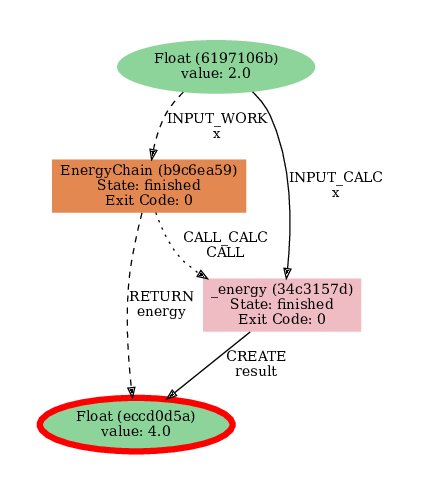

In [14]:
import subprocess
pk = result["energy"].pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)
# ! verdi node graph generate $pk と同じ。

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

同様に他の部分もWorkChain化しておく。


In [15]:
@calcfunction
def _force(x):
    return Float(-2.0*x)

class ForceChain(WorkChain):
    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("x", valid_type=Float)
        spec.outline(cls.force)
        spec.output("force",valid_type=Float)

    def force(self):
        x = self.inputs.x
        y = _force(x)
        self.out("force", y)


In [16]:
result, node = run.get_node(ForceChain, x=Float(2.0))
result, node

({'force': <Float: uuid: 7ba9ce40-f245-4c71-a09c-179cc492ec95 (pk: 11985) value: -4.0>},
 <WorkChainNode: uuid: b9501130-7a6b-4bcb-97e9-69f4ef6f2bdd (pk: 11983) (__main__.ForceChain)>)

Success: Output written to `11985.dot.pdf`


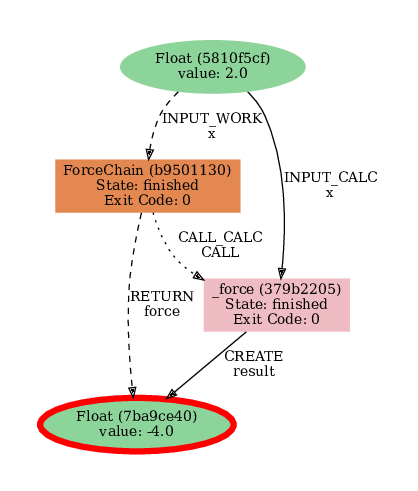

In [17]:
import subprocess
pk = result["force"].pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

In [18]:
@calcfunction
def _new_x(x,f,a):
    return Float(x+a*f)

class NewXChain(WorkChain):
    @classmethod
    def define(cls,spec):
        super().define(spec)
        spec.input("x", valid_type=Float)
        spec.input("f", valid_type=Float)
        spec.input("a", valid_type=Float)
        spec.outline(cls.new_x)
        spec.output("new_x",valid_type=Float)

    def new_x(self):
        x = self.inputs.x
        f = self.inputs.f
        a = self.inputs.a
        y = _new_x(x,f,a)
        self.out("new_x", y)

In [19]:
# 実行
result,node = run.get_node(NewXChain, x=Float(2.0), f=Float(-4.0), a=Float(0.6))
result,node

{'new_x': <Float: uuid: f7357e0d-99a1-4ff1-8d7c-82a6ed71c7de (pk: 11991) value: -0.4>}

Success: Output written to `11991.dot.pdf`


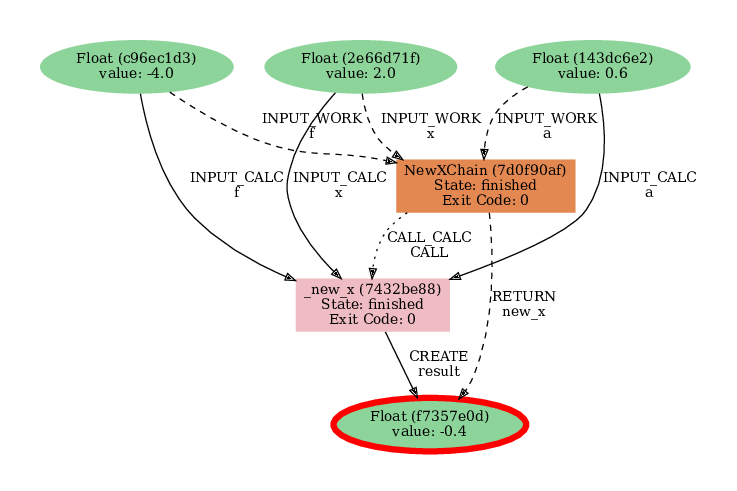

In [20]:
import subprocess
pk = result["new_x"].pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))